In [12]:
import pandas as pd

train = pd.read_csv(r'datafile/titanic_train.csv')
test = pd.read_csv(r'datafile/titanic_test.csv')

def feature_engineering(df):
    # Sex
    df['Sex'] = df['Sex'].map({'female': 0, 'male': 1})

    # Embarked
    df.Embarked.fillna('S', inplace=True)
    df['Embarked'] = df['Embarked'].map({'C': 0, 'Q': 1, 'S': 2})

    # Title
    df['Title'] = df.Name.str.extract(' ([A-Za-z]+)\.')
    df['Title'] = df['Title'].replace(['Capt', 'Col', 'Countess', 'Don','Dona', 'Dr', 'Jonkheer', 'Lady','Major', 'Rev', 'Sir'], 'Other')
    df['Title'] = df['Title'].replace('Mlle', 'Miss')
    df['Title'] = df['Title'].replace('Mme', 'Mrs')
    df['Title'] = df['Title'].replace('Ms', 'Miss')
    df['Title'] = df['Title'].map({'Master': 0, 'Miss': 1, 'Mr': 2, 'Mrs':3, 'Other':4})

    # Age
    meanAge = df[['Title', 'Age']].groupby(['Title']).mean()
    for index, row in meanAge.iterrows():
        nullIndex = df[(df.Title == index) & (df.Age.isnull())].index
        df.loc[nullIndex, 'Age'] = row[0]

    df['AgeCategory'] = pd.qcut(df.Age, 8, labels=range(1, 9))
    df.AgeCategory = df.AgeCategory.astype(int)

    # Cabin
    df.Cabin.fillna('N', inplace=True)
    df["CabinCategory"] = df["Cabin"].str.slice(start=0, stop=1)
    df["CabinCategory"] = df['CabinCategory'].map({ "N": 0, "C": 1, "B": 2, "D": 3, "E": 4, "A": 5, "F": 6, "G": 7, "T": 8 })

    # Fare
    df.Fare.fillna(0, inplace=True)
    df['FareCategory'] = pd.qcut(df.Fare, 8, labels=range(1, 9))
    df.FareCategory = df.FareCategory.astype(int)

    # SibSp, Parch
    df['Family'] = df['SibSp'] + df['Parch'] + 1
    df.loc[df["Family"] > 4, "Family"] = 5

    df['IsAlone'] = 1
    df.loc[df['Family'] > 1, 'IsAlone'] = 0

    # Ticket
    df['TicketCategory'] = df.Ticket.str.split()
    df['TicketCategory'] = [i[-1][0] for i in df['TicketCategory']]
    df['TicketCategory'] = df['TicketCategory'].replace(['8', '9', 'L'], '8')
    df['TicketCategory'] = pd.factorize(df['TicketCategory'])[0] + 1

    df.drop(['PassengerId', 'Ticket', 'Cabin', 'Fare', 'Name', 'Age', 'SibSp', 'Parch'], axis=1, inplace=True)

    return df

train = feature_engineering(train)
test = feature_engineering(test)

train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
Survived          891 non-null int64
Pclass            891 non-null int64
Sex               891 non-null int64
Embarked          891 non-null int64
Title             891 non-null int64
AgeCategory       891 non-null int64
CabinCategory     891 non-null int64
FareCategory      891 non-null int64
Family            891 non-null int64
IsAlone           891 non-null int64
TicketCategory    891 non-null int64
dtypes: int64(11)
memory usage: 76.6 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 10 columns):
Pclass            418 non-null int64
Sex               418 non-null int64
Embarked          418 non-null int64
Title             418 non-null int64
AgeCategory       418 non-null int64
CabinCategory     418 non-null int64
FareCategory      418 non-null int64
Family            418 non-null int64
IsAlone           418 non-null int64
TicketCate

In [13]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

#  Pclass, Sex, Embarked, Title, AgeCategory, CabinCategory, FareCategory, Family, IsAlone, TicketCategory 
data = train.drop('Survived', axis=1).values
# Survived
target = train['Survived'].values

In [14]:
x_train, x_valid, y_train, y_valid = train_test_split(data, target, test_size=0.4, stratify=target, random_state=0)

In [15]:
rf = RandomForestClassifier(n_estimators=50, criterion="entropy", max_depth=5, oob_score=True, random_state=10)
rf.fit(x_train, y_train)
prediction = rf.predict(x_valid)

length = y_valid.shape[0]
accuracy = accuracy_score(prediction, y_valid)
print(f'총 {length}명 중 {accuracy * 100:.3f}% 정확도로 생존을 맞춤')

총 357명 중 82.913% 정확도로 생존을 맞춤


In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

RF_classifier = RandomForestClassifier()

RF_paramgrid = {
    'max_depth' : [6, 8, 10, 15],
    'n_estimators': [50, 100, 300, 500, 700, 800, 900],
    'max_features': ['sqrt'],
    'min_samples_split': [2, 7, 15, 30],
    'min_samples_leaf': [1, 15, 30, 60],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy']
    }

k_fold = StratifiedKFold(n_splits=5)
RF_classifiergrid = GridSearchCV(RF_classifier, param_grid = RF_paramgrid, cv=k_fold, scoring="accuracy", n_jobs= -1, verbose=1)

RF_classifiergrid.fit(x_train, y_train)

rf = RF_classifiergrid.best_estimator_


print(RF_classifiergrid.best_score_)
0.8352059925093633

print(RF_classifiergrid.best_params_)
{'bootstrap': True, 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 7, 'n_estimators': 1200}

print(RF_classifiergrid.best_estimator_)
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=8, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=7,
                       min_weight_fraction_leaf=0.0, n_estimators=1200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Fitting 5 folds for each of 1792 candidates, totalling 8960 fits


[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 277 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done 527 tasks      | elapsed:   46.8s
[Parallel(n_jobs=-1)]: Done 877 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1327 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1877 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 2527 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 3277 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 4127 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 5077 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 6127 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 7277 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done 8527 tasks      | elapsed: 11.4min
[Parallel(n_jobs=-1)]: Done 8960 out of 8960 | elapsed: 12.0min finished


0.8333333333333334
{'bootstrap': True, 'criterion': 'entropy', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 7, 'n_estimators': 300}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=8, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=7,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=7,
            min_weight_fraction_leaf=0.0, n_estimators=1200, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

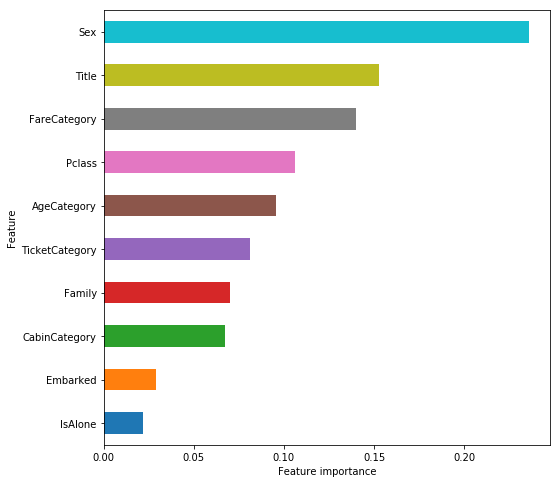

In [17]:
import matplotlib.pyplot as plt
from pandas import Series

feature_importance = rf.feature_importances_
fi = Series(feature_importance, index=train.drop(['Survived'], axis=1).columns)

plt.figure(figsize=(8, 8))
fi.sort_values(ascending=True).plot.barh()
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.show()


In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# data 분리 
data = train.drop('Survived', axis=1).values
target = train['Survived'].values
x_train, x_valid, y_train, y_valid = train_test_split(data, target, test_size=0.4, stratify=target, random_state=0)

# 모델 적용 함수 
def ml_fit(model):
    model.fit(x_train, y_train)
    prediction = model.predict(x_valid)
    accuracy = accuracy_score(prediction, y_valid)
    print(model)
    print(f'총 {y_valid.shape[0]}명 중 {accuracy * 100:.3f}% 정확도로 생존을 맞춤')
    return model

In [35]:
model = ml_fit(RandomForestClassifier(n_estimators=100))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
총 357명 중 80.952% 정확도로 생존을 맞춤


In [36]:
model = ml_fit(LogisticRegression(solver='lbfgs'))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False)
총 357명 중 79.832% 정확도로 생존을 맞춤


In [37]:
model = ml_fit(KNeighborsClassifier())

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')
총 357명 중 75.910% 정확도로 생존을 맞춤


In [38]:
model = ml_fit(GaussianNB())

GaussianNB(priors=None)
총 357명 중 73.389% 정확도로 생존을 맞춤


In [39]:
model = ml_fit(DecisionTreeClassifier())

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
총 357명 중 78.431% 정확도로 생존을 맞춤


In [43]:
model = ml_fit(RandomForestClassifier(n_estimators=50, criterion="entropy", max_depth=5, oob_score=True, random_state=10))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=True, random_state=10, verbose=0, warm_start=False)
총 357명 중 82.913% 정확도로 생존을 맞춤
